In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import optuna
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool
from sklearn.ensemble import RandomForestClassifier

In [85]:
base_data = pd.read_csv('HR_Analytics.csv', sep=';', index_col='ID')

In [86]:
base_data.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
ID,,,,,,,,,,,,,,,,,,,,,
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1.0,6,1,0,0,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,...,6.0,3,5,1,4,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,...,5.0,2,5,0,3,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,...,13.0,5,8,7,5,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,...,9.0,2,6,0,4,4.0,1.0,3.0,3,3


In [87]:
base_data.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'Department', 'DistanceFromHome',
       'Education', 'EducationField', 'EmployeeCount', 'Gender', 'JobLevel',
       'JobRole', 'MaritalStatus', 'MonthlyIncome', 'NumCompaniesWorked',
       'Over18', 'PercentSalaryHike', 'StandardHours', 'StockOptionLevel',
       'TotalWorkingYears', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'PerformanceRating'],
      dtype='object')

In [88]:
base_data.BusinessTravel.value_counts()

BusinessTravel
Travel_Rarely        3129
Travel_Frequently     831
Non-Travel            450
Name: count, dtype: int64

In [6]:
base_data['BusinessTravel']=base_data['BusinessTravel'].replace('Travel_Rarely','Non-Travel')

In [89]:
base_data['Attrition']=base_data['Attrition'].map({'Yes': 1,'No': 0})

In [90]:
base_data.dtypes

Age                          int64
Attrition                    int64
BusinessTravel              object
Department                  object
DistanceFromHome             int64
Education                    int64
EducationField              object
EmployeeCount                int64
Gender                      object
JobLevel                     int64
JobRole                     object
MaritalStatus               object
MonthlyIncome                int64
NumCompaniesWorked         float64
Over18                      object
PercentSalaryHike            int64
StandardHours                int64
StockOptionLevel             int64
TotalWorkingYears          float64
TrainingTimesLastYear        int64
YearsAtCompany               int64
YearsSinceLastPromotion      int64
YearsWithCurrManager         int64
EnvironmentSatisfaction    float64
JobSatisfaction            float64
WorkLifeBalance            float64
JobInvolvement               int64
PerformanceRating            int64
dtype: object

In [8]:
base_data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,4410.0,NaN,NaN,NaN,2204.5,1273.201673,0.0,1102.25,2204.5,3306.75,4409.0
Age,4410.0,NaN,NaN,NaN,36.92381,9.133301,18.0,30.0,36.0,43.0,60.0
Attrition,4410.0,NaN,NaN,NaN,0.161224,0.36778,0.0,0.0,0.0,0.0,1.0
BusinessTravel,4410,2,Non-Travel,3579,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Department,4410,3,Research & Development,2883,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DistanceFromHome,4410.0,NaN,NaN,NaN,9.192517,8.105026,1.0,2.0,7.0,14.0,29.0
Education,4410.0,NaN,NaN,NaN,2.912925,1.023933,1.0,2.0,3.0,4.0,5.0
EducationField,4410,6,Life Sciences,1818,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EmployeeCount,4410.0,NaN,NaN,NaN,1.0,0.0,1.0,1.0,1.0,1.0,1.0
Gender,4410,2,Male,2646,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: ylabel='MonthlyIncome'>

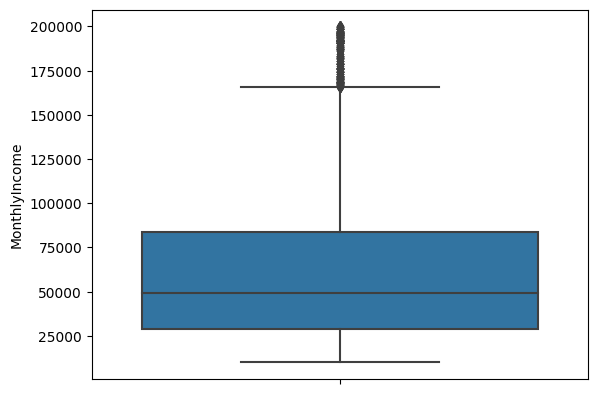

In [91]:
# Анализ выбросов
# box_sal = pd.DataFrame(data=base_data, columns=['PercentSalaryHike','DistanceFromHome'])
# sns.boxplot(data=box_sal)
sns.boxplot(data=base_data,y='MonthlyIncome')

In [92]:
#Обработка выбросов функцией межквартильного размаха
IQR = base_data['MonthlyIncome'].quantile(0.75) - base_data['MonthlyIncome'].quantile(0.25)
base_data = base_data[base_data['MonthlyIncome'] < base_data['MonthlyIncome'].quantile(0.75) + 1.5 * IQR]

In [93]:
base_data.isnull().sum()

Age                         0
Attrition                   0
BusinessTravel              0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
Gender                      0
JobLevel                    0
JobRole                     0
MaritalStatus               0
MonthlyIncome               0
NumCompaniesWorked         19
Over18                      0
PercentSalaryHike           0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           8
TrainingTimesLastYear       0
YearsAtCompany              0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
EnvironmentSatisfaction    20
JobSatisfaction            19
WorkLifeBalance            34
JobInvolvement              0
PerformanceRating           0
dtype: int64

In [9]:
#Заполнение пропущенных данных
value = {'NumCompaniesWorked': 0, 'TotalWorkingYears': 0 ,'EnvironmentSatisfaction': round(base_data['EnvironmentSatisfaction'].mean())
         ,'JobSatisfaction': round(base_data['JobSatisfaction'].mean()),'WorkLifeBalance': round(base_data['WorkLifeBalance'].mean())}
base_data = base_data.fillna(value)

In [94]:
base_data_target = base_data[(base_data['Attrition']==1)]

In [95]:
base_data_out_target = base_data[(base_data['Attrition']==0)]

In [96]:
#Сэмплирование выборки в соотношении 2 к 1
base_data_out_target_new = base_data_out_target.sample(n = len(base_data_target)*2)
base_data_new = pd.concat([base_data_out_target_new, base_data_target])

In [97]:
base_data_new.Attrition.value_counts()

Attrition
0    1326
1     663
Name: count, dtype: int64

In [110]:
#корреляция отсутствует
last_data = base_data_new.drop(['Over18','EmployeeCount','StandardHours'], axis=1)

In [111]:
last_data.shape

(1989, 25)

In [100]:
#мультиколлинеарность
last_data = last_data.drop(['PerformanceRating','TotalWorkingYears'], axis=1)

In [51]:
#бинарная кодировка
last_data = pd.get_dummies(last_data, columns=['EducationField','JobRole','MaritalStatus','Gender','BusinessTravel','Department'], dtype='int64')

In [114]:
data_corr = last_data.drop(['EducationField','JobRole','MaritalStatus','Gender','BusinessTravel','Department'], axis=1)

In [115]:
data_corr.corr()['Attrition'].sort_values()

TotalWorkingYears         -0.230574
Age                       -0.216223
YearsWithCurrManager      -0.189708
YearsAtCompany            -0.166146
JobSatisfaction           -0.116196
EnvironmentSatisfaction   -0.103670
WorkLifeBalance           -0.086787
TrainingTimesLastYear     -0.044171
YearsSinceLastPromotion   -0.036126
MonthlyIncome             -0.033740
DistanceFromHome          -0.033449
StockOptionLevel          -0.020359
Education                 -0.013426
JobInvolvement            -0.011784
JobLevel                   0.004893
PerformanceRating          0.017922
PercentSalaryHike          0.027772
NumCompaniesWorked         0.030229
Attrition                  1.000000
Name: Attrition, dtype: float64

<Axes: >

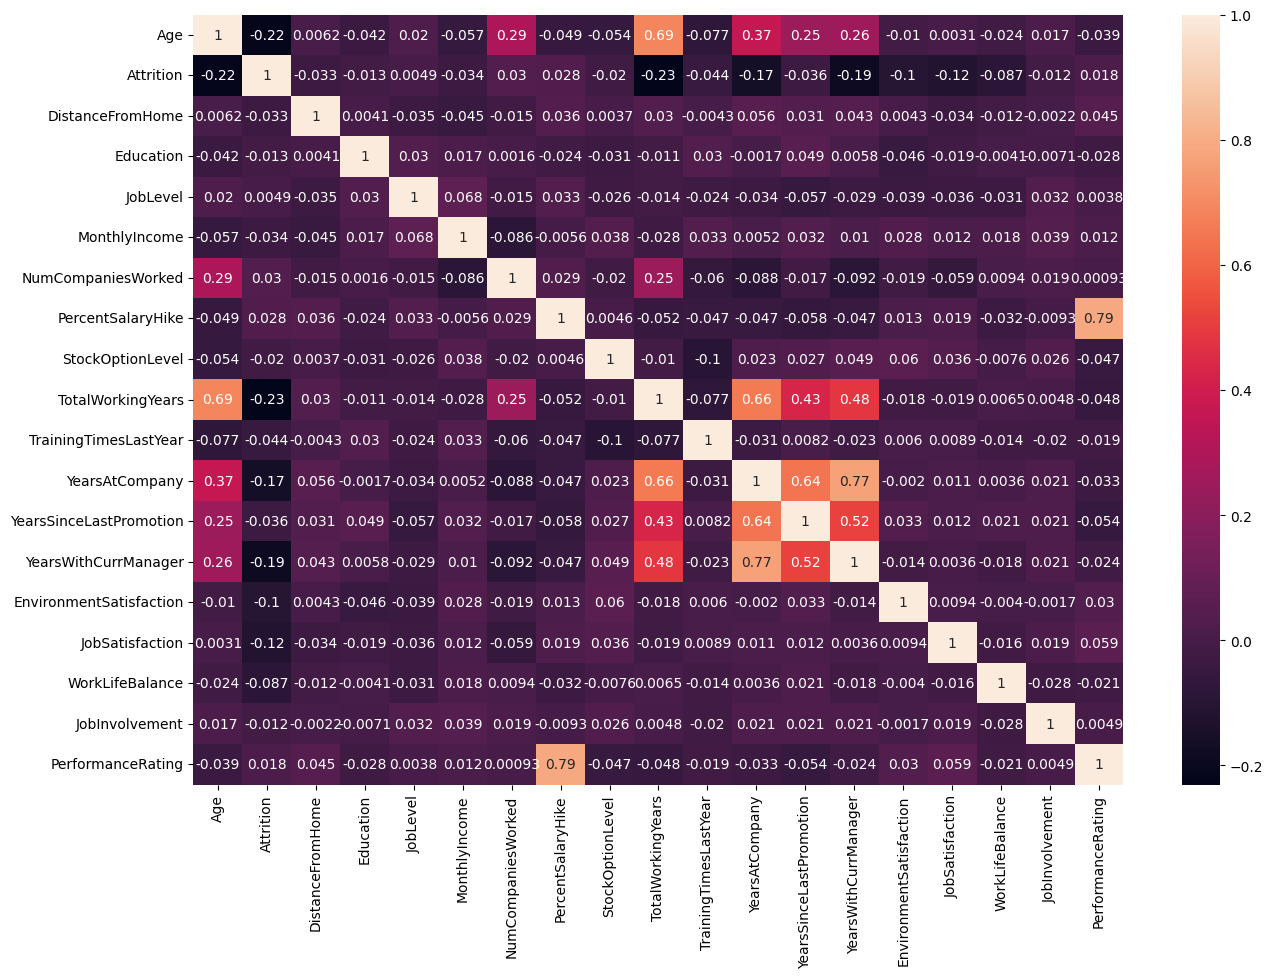

In [120]:
# Матрица корреляций
plt.subplots(figsize=(15, 10))
sns.heatmap(data_corr.corr(), annot=True)

In [101]:
X = last_data.drop('Attrition',axis=1)
y = last_data['Attrition']

In [102]:
# Разбиение выборки на обучающую и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [103]:
# model = RandomForestClassifier(n_estimators=150)
model = CatBoostClassifier(iterations=1000, depth=9)
cat_features = [X.columns.get_loc('EducationField'), X.columns.get_loc('JobRole'), X.columns.get_loc('MaritalStatus')
               , X.columns.get_loc('Gender'), X.columns.get_loc('BusinessTravel'), X.columns.get_loc('Department')]

In [65]:
# Кросс-валидация на минималках
lst=[]
lst.append(['CB',CatBoostClassifier(verbose=False)])
lst.append(['RF',RandomForestClassifier()])
for name, model in lst:
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=3).mean()
    print(f'{name}: {score}')

CB: 0.9422686037443828
RF: 0.960304063218694


In [28]:
#Оптимизация параметров модели
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 1000, 5000, step=1000),
        'depth': trial.suggest_int('depth', 6, 12),
        'verbose': trial.suggest_categorical('verbose', [False]),
    }
#     model = RandomForestClassifier(**param)
    model = CatBoostClassifier(**param)
    model.fit(X_train,y_train, cat_features=cat_features)
    y_pred = model.predict(X_test)
    score = roc_auc_score(y_test, y_pred)
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)

[I 2023-08-03 20:22:31,581] A new study created in memory with name: no-name-377aa5c8-2c25-478f-8ec1-468a5de5c37f
[I 2023-08-03 20:23:01,315] Trial 0 finished with value: 0.9826254826254825 and parameters: {'iterations': 2000, 'depth': 8, 'verbose': False}. Best is trial 0 with value: 0.9826254826254825.
[I 2023-08-03 20:25:24,040] Trial 1 finished with value: 0.9864864864864865 and parameters: {'iterations': 2000, 'depth': 11, 'verbose': False}. Best is trial 1 with value: 0.9864864864864865.
[I 2023-08-03 20:27:47,671] Trial 2 finished with value: 0.9864864864864865 and parameters: {'iterations': 2000, 'depth': 11, 'verbose': False}. Best is trial 1 with value: 0.9864864864864865.
[I 2023-08-03 20:28:32,311] Trial 3 finished with value: 0.9826254826254825 and parameters: {'iterations': 3000, 'depth': 8, 'verbose': False}. Best is trial 1 with value: 0.9864864864864865.
[I 2023-08-03 20:29:44,262] Trial 4 finished with value: 0.9864864864864865 and parameters: {'iterations': 1000, 'de

In [30]:
study.best_params

{'iterations': 1000, 'depth': 9, 'verbose': False}

In [104]:
# Обучаем модель
model.fit(X_train,y_train, cat_features=cat_features)
# model.fit(X_train,y_train, cat_features=cat_features, eval_set=(X_test, y_test), verbose=False)

Learning rate set to 0.012562
0:	learn: 0.6879505	total: 19.2ms	remaining: 19.2s
1:	learn: 0.6821913	total: 46.5ms	remaining: 23.2s
2:	learn: 0.6763639	total: 73ms	remaining: 24.3s
3:	learn: 0.6704055	total: 95.9ms	remaining: 23.9s
4:	learn: 0.6658231	total: 122ms	remaining: 24.2s
5:	learn: 0.6601831	total: 143ms	remaining: 23.8s
6:	learn: 0.6527494	total: 170ms	remaining: 24.1s
7:	learn: 0.6476951	total: 194ms	remaining: 24s
8:	learn: 0.6413194	total: 219ms	remaining: 24.1s
9:	learn: 0.6395551	total: 228ms	remaining: 22.5s
10:	learn: 0.6320645	total: 250ms	remaining: 22.5s
11:	learn: 0.6262774	total: 273ms	remaining: 22.4s
12:	learn: 0.6211371	total: 293ms	remaining: 22.3s
13:	learn: 0.6159979	total: 320ms	remaining: 22.5s
14:	learn: 0.6103818	total: 344ms	remaining: 22.6s
15:	learn: 0.6059112	total: 366ms	remaining: 22.5s
16:	learn: 0.6015906	total: 389ms	remaining: 22.5s
17:	learn: 0.5984821	total: 414ms	remaining: 22.6s
18:	learn: 0.5967064	total: 424ms	remaining: 21.9s
19:	learn: 

164:	learn: 0.2880830	total: 3.75s	remaining: 19s
165:	learn: 0.2870585	total: 3.78s	remaining: 19s
166:	learn: 0.2853070	total: 3.8s	remaining: 19s
167:	learn: 0.2836569	total: 3.82s	remaining: 18.9s
168:	learn: 0.2818664	total: 3.85s	remaining: 18.9s
169:	learn: 0.2805371	total: 3.87s	remaining: 18.9s
170:	learn: 0.2796956	total: 3.89s	remaining: 18.9s
171:	learn: 0.2780228	total: 3.92s	remaining: 18.9s
172:	learn: 0.2769285	total: 3.94s	remaining: 18.8s
173:	learn: 0.2759515	total: 3.96s	remaining: 18.8s
174:	learn: 0.2748855	total: 3.99s	remaining: 18.8s
175:	learn: 0.2737192	total: 4.01s	remaining: 18.8s
176:	learn: 0.2724550	total: 4.03s	remaining: 18.7s
177:	learn: 0.2712647	total: 4.05s	remaining: 18.7s
178:	learn: 0.2705198	total: 4.08s	remaining: 18.7s
179:	learn: 0.2690095	total: 4.1s	remaining: 18.7s
180:	learn: 0.2682952	total: 4.13s	remaining: 18.7s
181:	learn: 0.2672323	total: 4.16s	remaining: 18.7s
182:	learn: 0.2659262	total: 4.18s	remaining: 18.7s
183:	learn: 0.264975

333:	learn: 0.1622075	total: 7.76s	remaining: 15.5s
334:	learn: 0.1616856	total: 7.78s	remaining: 15.4s
335:	learn: 0.1608719	total: 7.81s	remaining: 15.4s
336:	learn: 0.1603971	total: 7.83s	remaining: 15.4s
337:	learn: 0.1598311	total: 7.86s	remaining: 15.4s
338:	learn: 0.1595731	total: 7.88s	remaining: 15.4s
339:	learn: 0.1590276	total: 7.9s	remaining: 15.3s
340:	learn: 0.1586917	total: 7.93s	remaining: 15.3s
341:	learn: 0.1581524	total: 7.95s	remaining: 15.3s
342:	learn: 0.1576247	total: 7.98s	remaining: 15.3s
343:	learn: 0.1570965	total: 8s	remaining: 15.3s
344:	learn: 0.1565599	total: 8.03s	remaining: 15.2s
345:	learn: 0.1559044	total: 8.05s	remaining: 15.2s
346:	learn: 0.1551628	total: 8.08s	remaining: 15.2s
347:	learn: 0.1545644	total: 8.1s	remaining: 15.2s
348:	learn: 0.1541211	total: 8.13s	remaining: 15.2s
349:	learn: 0.1536827	total: 8.16s	remaining: 15.1s
350:	learn: 0.1532082	total: 8.2s	remaining: 15.2s
351:	learn: 0.1527638	total: 8.22s	remaining: 15.1s
352:	learn: 0.1523

492:	learn: 0.1034550	total: 11.6s	remaining: 11.9s
493:	learn: 0.1032449	total: 11.6s	remaining: 11.9s
494:	learn: 0.1031446	total: 11.6s	remaining: 11.8s
495:	learn: 0.1027744	total: 11.6s	remaining: 11.8s
496:	learn: 0.1024892	total: 11.7s	remaining: 11.8s
497:	learn: 0.1024644	total: 11.7s	remaining: 11.8s
498:	learn: 0.1022691	total: 11.7s	remaining: 11.7s
499:	learn: 0.1019270	total: 11.7s	remaining: 11.7s
500:	learn: 0.1015299	total: 11.7s	remaining: 11.7s
501:	learn: 0.1010549	total: 11.8s	remaining: 11.7s
502:	learn: 0.1006459	total: 11.8s	remaining: 11.6s
503:	learn: 0.1004815	total: 11.8s	remaining: 11.6s
504:	learn: 0.1001077	total: 11.8s	remaining: 11.6s
505:	learn: 0.0996576	total: 11.9s	remaining: 11.6s
506:	learn: 0.0993105	total: 11.9s	remaining: 11.6s
507:	learn: 0.0990758	total: 11.9s	remaining: 11.5s
508:	learn: 0.0987526	total: 11.9s	remaining: 11.5s
509:	learn: 0.0984543	total: 12s	remaining: 11.5s
510:	learn: 0.0984520	total: 12s	remaining: 11.4s
511:	learn: 0.09

657:	learn: 0.0664173	total: 15.4s	remaining: 8.02s
658:	learn: 0.0661986	total: 15.5s	remaining: 8s
659:	learn: 0.0660414	total: 15.5s	remaining: 7.98s
660:	learn: 0.0658877	total: 15.5s	remaining: 7.95s
661:	learn: 0.0656348	total: 15.5s	remaining: 7.93s
662:	learn: 0.0654953	total: 15.6s	remaining: 7.91s
663:	learn: 0.0653095	total: 15.6s	remaining: 7.88s
664:	learn: 0.0650935	total: 15.6s	remaining: 7.86s
665:	learn: 0.0648505	total: 15.6s	remaining: 7.83s
666:	learn: 0.0647285	total: 15.7s	remaining: 7.81s
667:	learn: 0.0646642	total: 15.7s	remaining: 7.79s
668:	learn: 0.0644144	total: 15.7s	remaining: 7.77s
669:	learn: 0.0643040	total: 15.7s	remaining: 7.74s
670:	learn: 0.0640915	total: 15.8s	remaining: 7.72s
671:	learn: 0.0638383	total: 15.8s	remaining: 7.7s
672:	learn: 0.0636577	total: 15.8s	remaining: 7.68s
673:	learn: 0.0634558	total: 15.8s	remaining: 7.65s
674:	learn: 0.0633019	total: 15.8s	remaining: 7.63s
675:	learn: 0.0630884	total: 15.9s	remaining: 7.6s
676:	learn: 0.062

816:	learn: 0.0435566	total: 19.2s	remaining: 4.3s
817:	learn: 0.0434448	total: 19.2s	remaining: 4.27s
818:	learn: 0.0433107	total: 19.2s	remaining: 4.25s
819:	learn: 0.0432420	total: 19.3s	remaining: 4.23s
820:	learn: 0.0431381	total: 19.3s	remaining: 4.21s
821:	learn: 0.0430487	total: 19.3s	remaining: 4.18s
822:	learn: 0.0429294	total: 19.3s	remaining: 4.16s
823:	learn: 0.0428628	total: 19.4s	remaining: 4.13s
824:	learn: 0.0427633	total: 19.4s	remaining: 4.11s
825:	learn: 0.0426662	total: 19.4s	remaining: 4.09s
826:	learn: 0.0425694	total: 19.4s	remaining: 4.06s
827:	learn: 0.0425139	total: 19.5s	remaining: 4.04s
828:	learn: 0.0424193	total: 19.5s	remaining: 4.02s
829:	learn: 0.0423509	total: 19.5s	remaining: 3.99s
830:	learn: 0.0422235	total: 19.5s	remaining: 3.97s
831:	learn: 0.0421568	total: 19.5s	remaining: 3.95s
832:	learn: 0.0420342	total: 19.6s	remaining: 3.92s
833:	learn: 0.0419129	total: 19.6s	remaining: 3.9s
834:	learn: 0.0418412	total: 19.6s	remaining: 3.88s
835:	learn: 0.

977:	learn: 0.0307501	total: 23s	remaining: 516ms
978:	learn: 0.0306962	total: 23s	remaining: 493ms
979:	learn: 0.0306496	total: 23s	remaining: 470ms
980:	learn: 0.0305662	total: 23s	remaining: 446ms
981:	learn: 0.0305077	total: 23.1s	remaining: 423ms
982:	learn: 0.0304607	total: 23.1s	remaining: 399ms
983:	learn: 0.0304200	total: 23.1s	remaining: 376ms
984:	learn: 0.0303963	total: 23.1s	remaining: 352ms
985:	learn: 0.0303364	total: 23.2s	remaining: 329ms
986:	learn: 0.0302782	total: 23.2s	remaining: 305ms
987:	learn: 0.0302338	total: 23.2s	remaining: 282ms
988:	learn: 0.0301680	total: 23.2s	remaining: 258ms
989:	learn: 0.0301248	total: 23.2s	remaining: 235ms
990:	learn: 0.0300593	total: 23.3s	remaining: 211ms
991:	learn: 0.0300023	total: 23.3s	remaining: 188ms
992:	learn: 0.0299779	total: 23.3s	remaining: 164ms
993:	learn: 0.0299264	total: 23.3s	remaining: 141ms
994:	learn: 0.0298694	total: 23.4s	remaining: 117ms
995:	learn: 0.0298204	total: 23.4s	remaining: 93.9ms
996:	learn: 0.02977

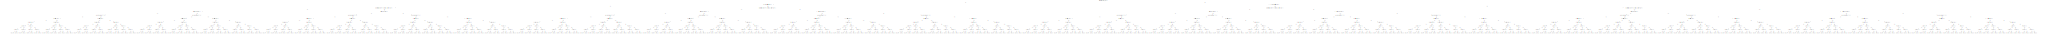

In [105]:
#Пример реализации одного дерева
# pool = Pool(X_test, cat_features=cat_features)
model.plot_tree(tree_idx=998, pool=X_test)
# plot_tree(model.estimators_[99],filled=True, impurity=True, max_depth=5, fontsize=5)

In [64]:
#feature_importances
feat_imp = pd.Series(model.feature_importances_,last_data.drop('Attrition',axis=1).columns)
feat_imp.sort_values(ascending=False)
# feat_imp.nlargest(20).sort_values().plot.barh()
# plt.tick_params(axis='both', which='major', labelsize=8)

Age                                  0.090188
YearsAtCompany                       0.080253
MonthlyIncome                        0.074524
YearsWithCurrManager                 0.064504
DistanceFromHome                     0.055910
PercentSalaryHike                    0.053812
NumCompaniesWorked                   0.045013
YearsSinceLastPromotion              0.038346
JobSatisfaction                      0.037531
TrainingTimesLastYear                0.035886
EnvironmentSatisfaction              0.035281
WorkLifeBalance                      0.032295
Education                            0.030236
JobLevel                             0.028118
MaritalStatus_Single                 0.025142
JobInvolvement                       0.023512
StockOptionLevel                     0.023190
BusinessTravel_Travel_Frequently     0.013657
EducationField_Medical               0.013367
JobRole_Research Scientist           0.013350
BusinessTravel_Non-Travel            0.012927
JobRole_Sales Executive           

In [106]:
# Предсказание
y_pred = model.predict(X_test)

In [107]:
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[254,   5],
       [  1, 138]], dtype=int64)

In [108]:
roc_auc_score(y_test, y_pred)

0.9867503680453321

In [71]:
#RandomForestClassifier
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[250,   9],
       [  0, 139]], dtype=int64)

In [36]:
#CatboostClassifier
matrix = confusion_matrix(y_test, y_pred)
matrix

array([[253,   6],
       [  0, 139]], dtype=int64)

In [72]:
#RandomForestClassifier
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       259
           1       0.94      1.00      0.97       139

    accuracy                           0.98       398
   macro avg       0.97      0.98      0.98       398
weighted avg       0.98      0.98      0.98       398



In [109]:
#CatboostClassifier
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       259
           1       0.97      0.99      0.98       139

    accuracy                           0.98       398
   macro avg       0.98      0.99      0.98       398
weighted avg       0.99      0.98      0.98       398



In [73]:
#RandomForestClassifier
roc_auc_score(y_test, y_pred)

0.9826254826254825

In [38]:
#CatboostClassifier
roc_auc_score(y_test, y_pred)

0.9884169884169884

In [62]:
#RandomForestClassifier
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

In [39]:
#CatboostClassifier
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


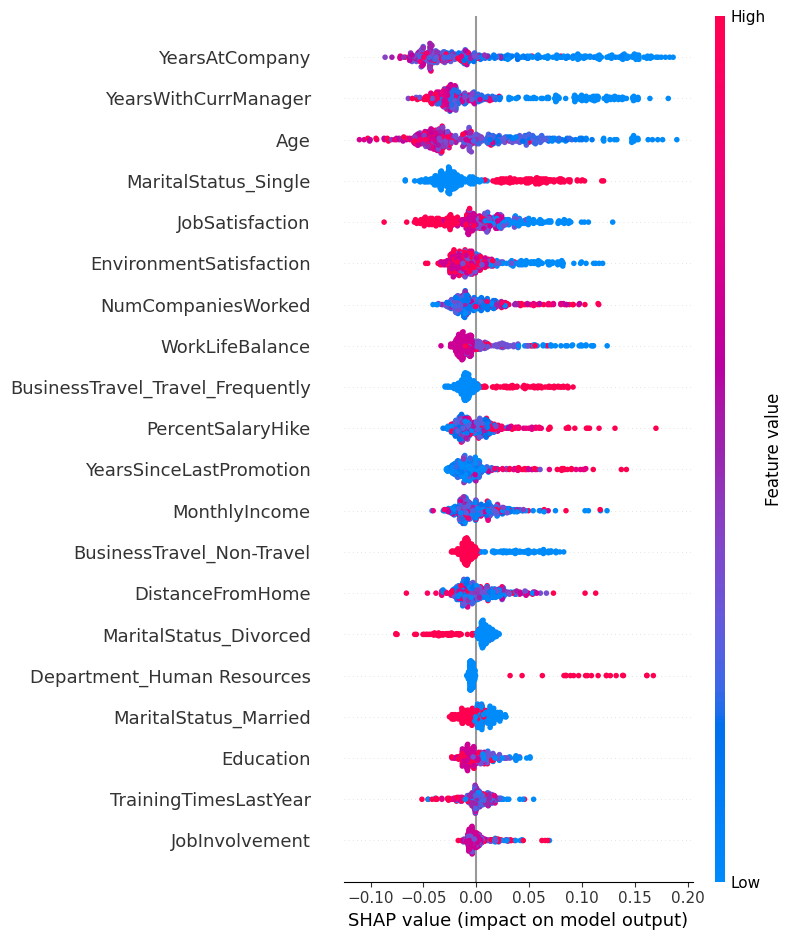

In [63]:
#RandomForestClassifier
shap.summary_plot(shap_values[1],X_test, max_display=20)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


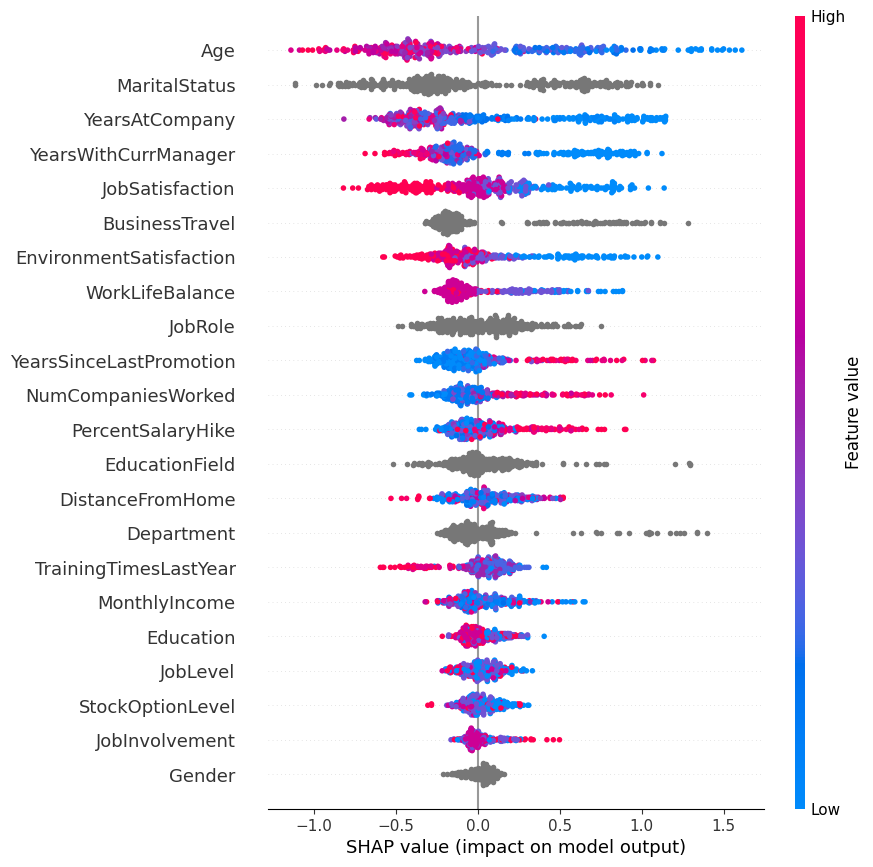

In [49]:
#CatboostClassifier
shap.plots.beeswarm(shap_values, max_display=25)

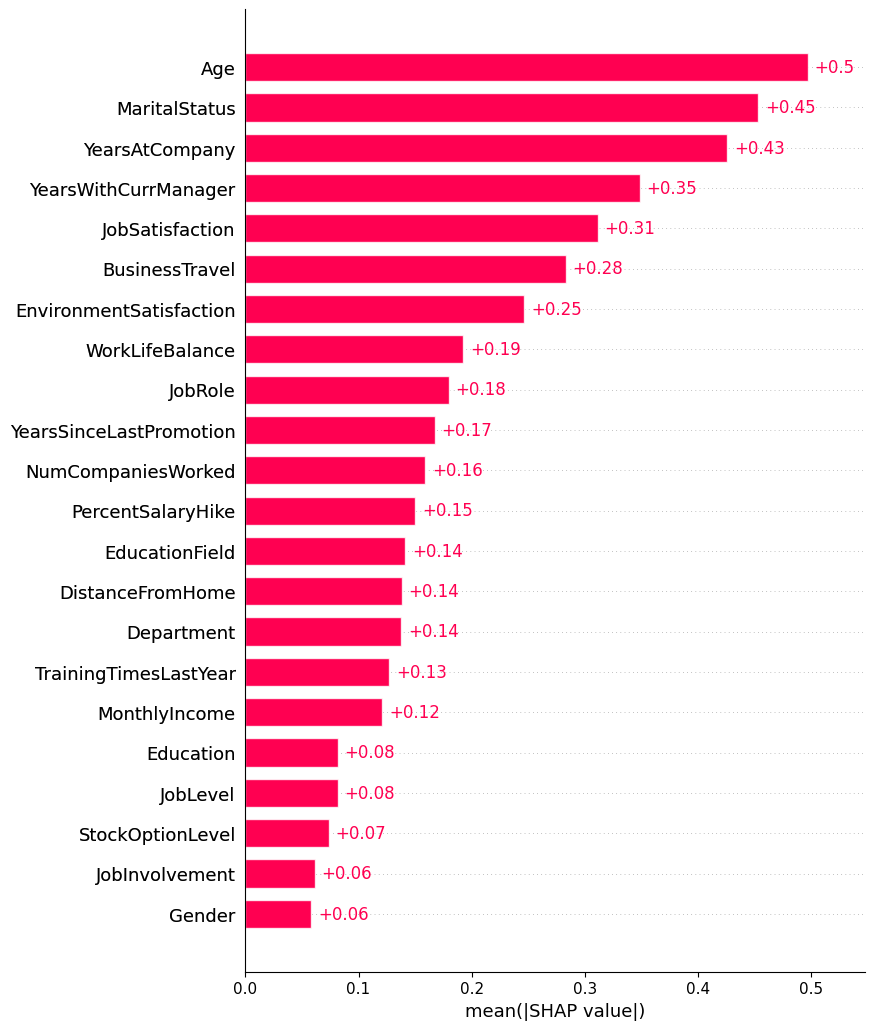

In [50]:
#CatboostClassifier
shap.plots.bar(shap_values,max_display=25)

In [125]:
#CatboostClassifier
shap.initjs()
shap.plots.force(shap_values[3])

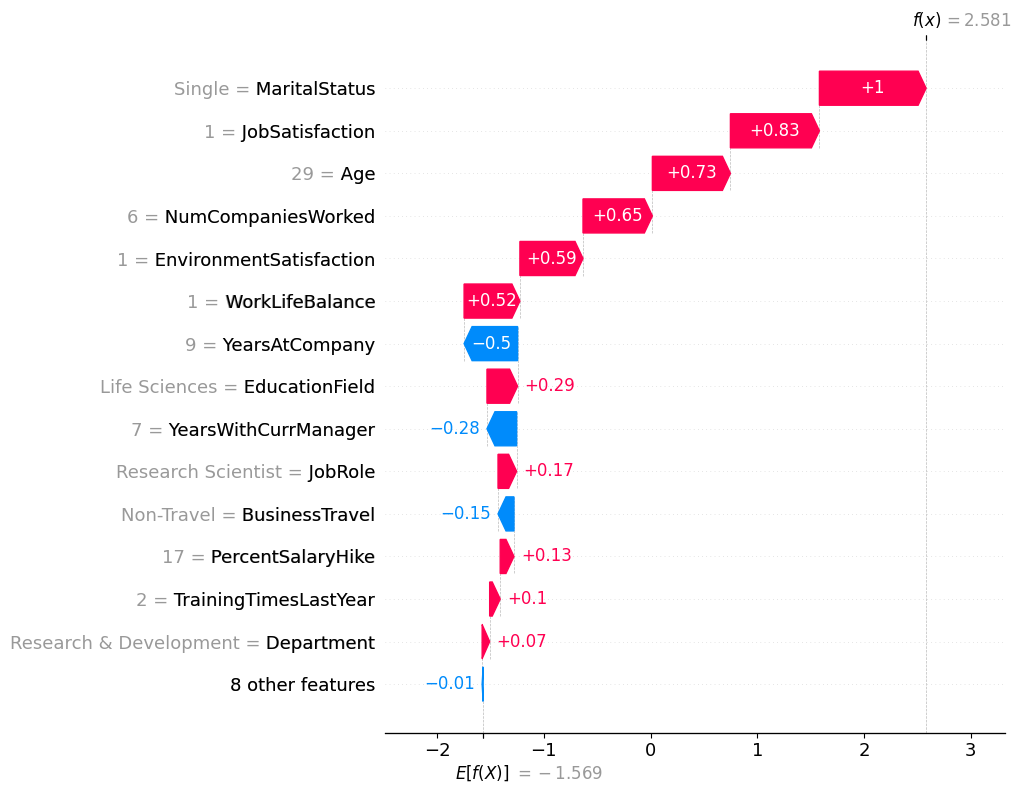

In [48]:
#CatboostClassifier
shap.plots.waterfall(shap_values[7],max_display=15)

In [83]:
# Сохранение модели
# import pickle
# filename = 'finalized_model_boost.sav'
# pickle.dump(model, open(filename, 'wb'))

In [145]:
import pickle
model = pickle.load(open('finalized_model_boost.sav', 'rb'))

In [2]:
import pandas as pd
import numpy as np
from catboost import Pool
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [76]:
pred = pd.read_csv('test_pred_cat.csv',sep=',')

In [77]:
pred['ID'] = np.arange(len(pred))[:]+1

In [56]:
pred.columns

Index(['Age', 'BusinessTravel', 'Department', 'DistanceFromHome', 'Education',
       'EducationField', 'Gender', 'JobLevel', 'JobRole', 'MaritalStatus',
       'MonthlyIncome', 'NumCompaniesWorked', 'PercentSalaryHike',
       'StockOptionLevel', 'TrainingTimesLastYear', 'YearsAtCompany',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'EnvironmentSatisfaction', 'JobSatisfaction', 'WorkLifeBalance',
       'JobInvolvement', 'ID'],
      dtype='object')

In [78]:
X_pred = pred.drop(['ID'], axis=1)
cat_features = [1,2,5,6,8,9]
X_pred_cat = Pool(X_pred, cat_features=cat_features)
predictions=model.predict_proba(X_pred_cat)
mtr_pred=[]
for index in range(len(predictions)):
    id_n = round(pred['ID'][index])
    prob = round(predictions[index][1],2)
    mtr_pred.append([id_n,prob])

In [79]:
print(np.array(mtr_pred[:10]))

[[1.   0.23]
 [2.   0.07]
 [3.   0.07]]


In [158]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_pred)
shap.initjs()
shap.plots.force(explainer.expected_value[1], shap_values[1][0], X_pred.iloc[[0]])

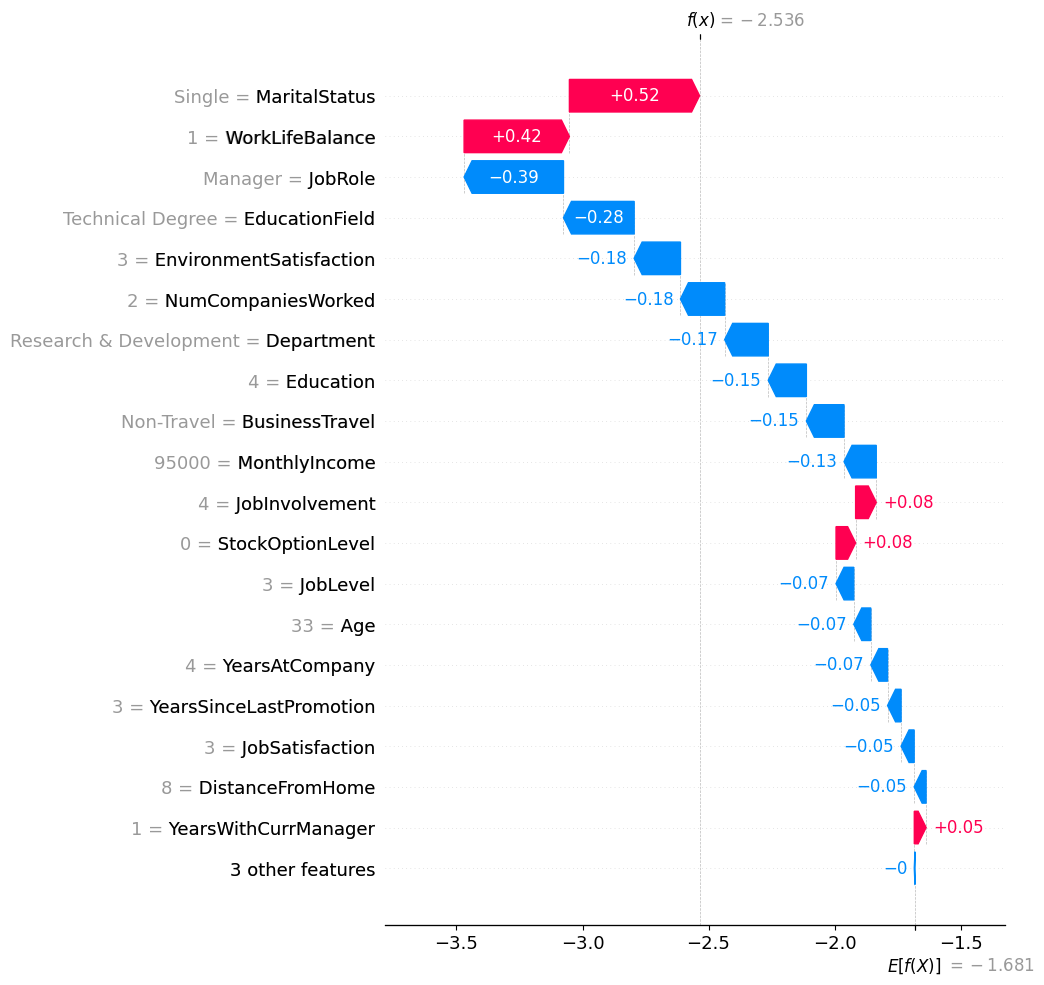

In [82]:
explainer = shap.Explainer(model)
shap_values = explainer(X_pred)
shap.plots.waterfall(shap_values[1], max_display=20)